In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
# import xgboost as xgb
import sklearn.metrics



In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('data/new_sales_train.csv')
df.head()

,average_weekly_sales,week,date,var_prev_week,avg_prev_week,avg_price,std_in_price
0,44.74,1,2014-01-05,7.13,42.30,4.86,0.52
1,41.48,2,2014-01-12,9.58,44.74,4.87,0.49
2,31.35,3,2014-01-19,6.31,41.48,4.88,0.47
3,32.49,4,2014-01-26,-3.81,31.35,4.89,0.46
4,34.63,5,2014-02-02,-2.67,32.49,4.88,0.47


In [27]:
x = df[['var_prev_week','avg_prev_week','avg_price','std_in_price']]
y = df[['average_weekly_sales']]

x_train, x_test, y_train, y_test = train_test_split(x,y, shuffle=False, train_size=0.8)
y_test.head()

,average_weekly_sales
42,30.33
43,29.23
44,38.91
45,40.04
46,39.32


In [28]:
xgbmodel = xgb.XGBRegressor(booster='gbtree')
parameters = {'objective':['reg:squarederror', 'reg:squaredlogerror', 'reg:linear', 
                           'reg:pseudohubererror', 'reg:gamma', 'reg:tweedie', 'reg:absoluteerror'], 
             'max_depth':[3,5,7,9],
             'learning_rate':[0.01,0.1,0.5]}

clf = GridSearchCV(xgbmodel, parameters, verbose=0)
clf.fit(x,y)



NameError: name 'xgb' is not defined

In [74]:
results = pd.DataFrame(clf.cv_results_)
results = results[['params','mean_test_score','rank_test_score']]

In [75]:
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)

In [76]:
results.sort_values(by='rank_test_score')[0:2]

,params,mean_test_score,rank_test_score
0,"{'learning_rate': 0.01, 'max_depth': 3, 'objective': 'reg:squarederror'}",-0.77,1
2,"{'learning_rate': 0.01, 'max_depth': 3, 'objective': 'reg:linear'}",-0.77,1


In [97]:
xgbmodel = clf.best_estimator_
xgbmodel.fit(x_train,y_train, verbose=100)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature Importance'}>

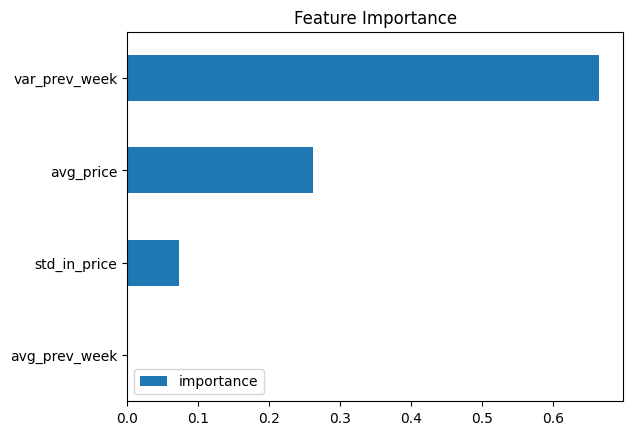

In [88]:
fi = pd.DataFrame(data=xgbmodel.feature_importances_,
                  index=xgbmodel.feature_names_in_,
                  columns = ['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

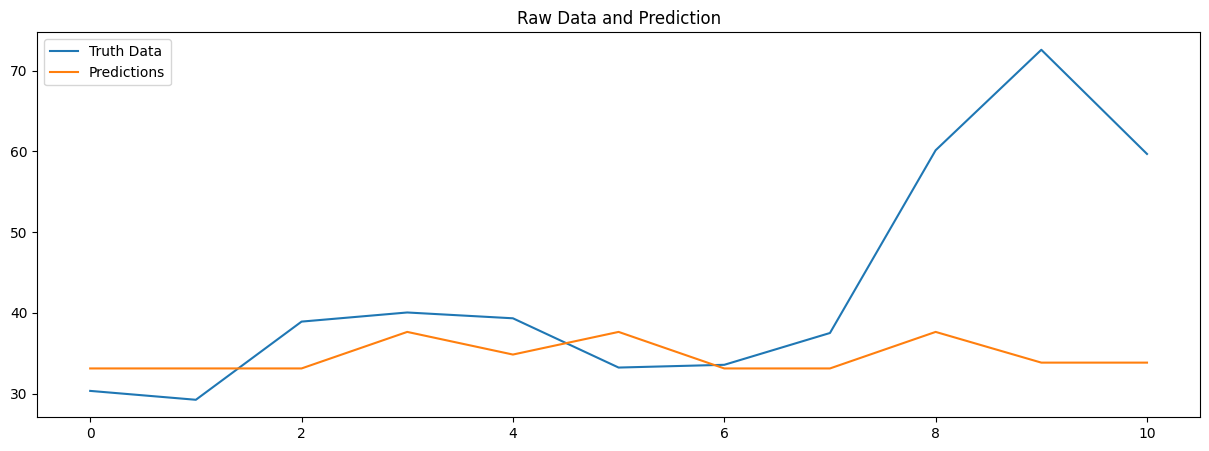

In [99]:
test = pd.DataFrame()
test['prediction'] = xgbmodel.predict(x_test)
test['label'] = list(y_test['average_weekly_sales'])
ax = test['label'].plot(figsize=(15, 5))
test['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [104]:
y_pred = xgbmodel.predict(x_test)


In [107]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error,r2_score



In [108]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mae,mse,rmse,r2)

10.51673246903853 254.16362027179332 15.942509848571314 -0.36400604248046875


# S/ARIMA

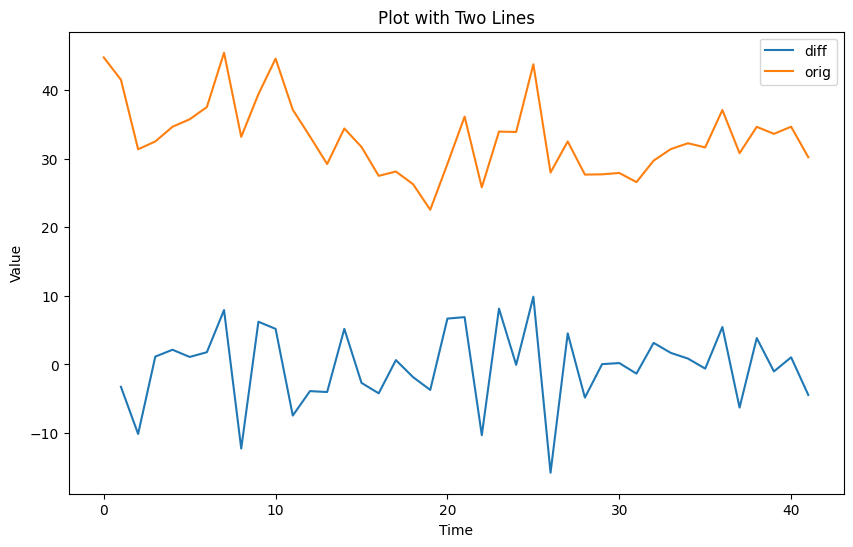

In [125]:
train_diff = y_train.diff().dropna()

plt.figure(figsize=(10, 6))
plt.plot(train_diff, label='diff')
plt.plot(y_train, label='orig')



plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Plot with Two Lines')
plt.legend()

# Show the plot
plt.show()

In [126]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(y_train)
print(f'p-value: {adf_test[1]}')

p-value: 0.2378328968954314


In [127]:

adf_test = adfuller(train_diff)
print(f'p-value: {adf_test[1]}')

p-value: 6.967499127411169e-17


In [29]:
import pmdarima as pm

In [30]:
autoarima = pm.auto_arima(y_train, stepwise=False)
autoarima

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

In [134]:
autoarimax = pm.auto_arima(y=y_train, x=x_train, stepwise=False)
autoarimax

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

In [131]:
autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   42
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -126.307
Date:                Tue, 10 Sep 2024   AIC                            258.615
Time:                        20:45:09   BIC                            263.828
Sample:                             0   HQIC                           260.526
                                 - 42                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     18.9344      5.268      3.594      0.000       8.610      29.259
ar.L1          0.4302      0.147      2.935      0.003       0.143       0.717
sigma2        23.8525      5.827      4.093      0.000      12.432      35.273
===================================================================================
Ljung-Box (L1) (Q):                   0.58   Jarque-Bera (JB):                 1.13
Prob(Q):                              0.45   Prob(JB):                         0.57
Heteroskedasticity (H):               0.29   Skew:                             0.39
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [135]:
autoarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   42
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -126.307
Date:                Tue, 10 Sep 2024   AIC                            258.615
Time:                        20:50:23   BIC                            263.828
Sample:                             0   HQIC                           260.526
                                 - 42                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     18.9344      5.268      3.594      0.000       8.610      29.259
ar.L1          0.4302      0.147      2.935      0.003       0.143       0.717
sigma2        23.8525      5.827      4.093      0.000      12.432      35.273
===================================================================================
Ljung-Box (L1) (Q):                   0.58   Jarque-Bera (JB):                 1.13
Prob(Q):                              0.45   Prob(JB):                         0.57
Heteroskedasticity (H):               0.29   Skew:                             0.39
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
y_test

,average_weekly_sales
42,30.33
43,29.23
44,38.91
45,40.04
46,39.32
47,33.22
48,33.56
49,37.50
50,60.13
51,72.57


In [137]:
df

,average_weekly_sales,week,var_prev_week,avg_prev_week,avg_price,std_in_price
0,44.74,1,0.91,0.91,-1.56,1.36
1,41.48,2,1.20,1.20,-1.20,0.93
2,31.35,3,0.81,0.81,-0.85,0.64
3,32.49,4,-0.42,-0.42,-0.49,0.50
4,34.63,5,-0.28,-0.29,-0.85,0.64
5,35.72,6,-0.03,-0.03,-0.49,0.36
6,37.50,7,0.11,0.11,-1.20,1.07
7,45.42,8,0.32,0.32,-0.13,0.07
8,33.16,9,1.29,1.29,-0.85,0.79
9,39.38,10,-0.20,-0.20,-0.49,0.36


In [31]:
forecast = autoarima.predict(n_periods=11)
forecast = forecast.reset_index()
test['prediction_arima'] = forecast[0]
test.head()

,y,ds,prediction_arima
0,30.19,2014-10-19,31.921277
1,30.33,2014-10-26,32.666026
2,29.23,2014-11-02,32.986397
3,38.91,2014-11-09,33.124212
4,40.04,2014-11-16,33.183496


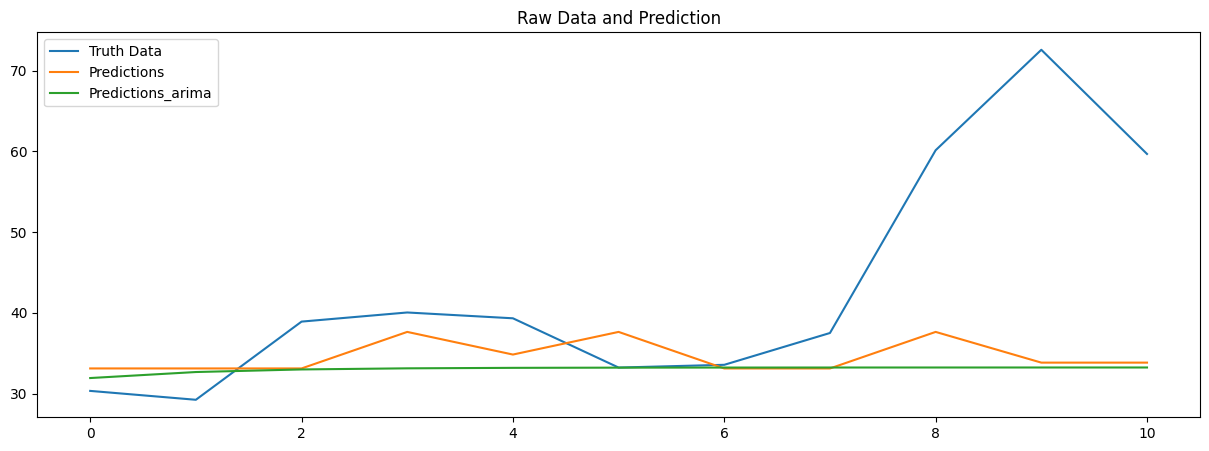

In [166]:
ax = test['label'].plot(figsize=(15, 5))
test['prediction'].plot(ax=ax, style='-')
test['prediction_arima'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions', 'Predictions_arima'])
ax.set_title('Raw Data and Prediction')
plt.show()

# Prophet

In [6]:
from prophet import Prophet

/Users/cex/opt/anaconda3/envs/interview/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
df['date'] = pd.to_datetime(df['date'])
df.head()

,average_weekly_sales,week,date,var_prev_week,avg_prev_week,avg_price,std_in_price
0,44.74,1,2014-01-05,7.13,42.30,4.86,0.52
1,41.48,2,2014-01-12,9.58,44.74,4.87,0.49
2,31.35,3,2014-01-19,6.31,41.48,4.88,0.47
3,32.49,4,2014-01-26,-3.81,31.35,4.89,0.46
4,34.63,5,2014-02-02,-2.67,32.49,4.88,0.47


In [19]:
train = df[['average_weekly_sales','date']][:41]
train = train.reset_index(drop=True).rename(columns={'date':'ds', 'average_weekly_sales':'y'})

test = df[['average_weekly_sales','date']][41:]
test = test.reset_index(drop=True).rename(columns={'date':'ds', 'average_weekly_sales':'y'})

test.head()

,y,ds
0,30.19,2014-10-19
1,30.33,2014-10-26
2,29.23,2014-11-02
3,38.91,2014-11-09
4,40.04,2014-11-16


In [21]:
model = Prophet()
model.fit(train)

21:52:07 - cmdstanpy - INFO - Chain [1] start processing
21:52:09 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
results = model.predict(test)
results.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-10-19,29.536201,23.506233,35.562728,29.536199,29.536203,0.0,0.0,0.0,0.0,0.0,0.0,29.536201
1,2014-10-26,29.364554,23.324634,35.909685,29.364548,29.364561,0.0,0.0,0.0,0.0,0.0,0.0,29.364554
2,2014-11-02,29.192908,23.139584,35.592404,29.192894,29.192921,0.0,0.0,0.0,0.0,0.0,0.0,29.192908
3,2014-11-09,29.021261,22.933223,35.058061,29.021238,29.021282,0.0,0.0,0.0,0.0,0.0,0.0,29.021261
4,2014-11-16,28.849614,22.973515,35.381496,28.849583,28.849644,0.0,0.0,0.0,0.0,0.0,0.0,28.849614


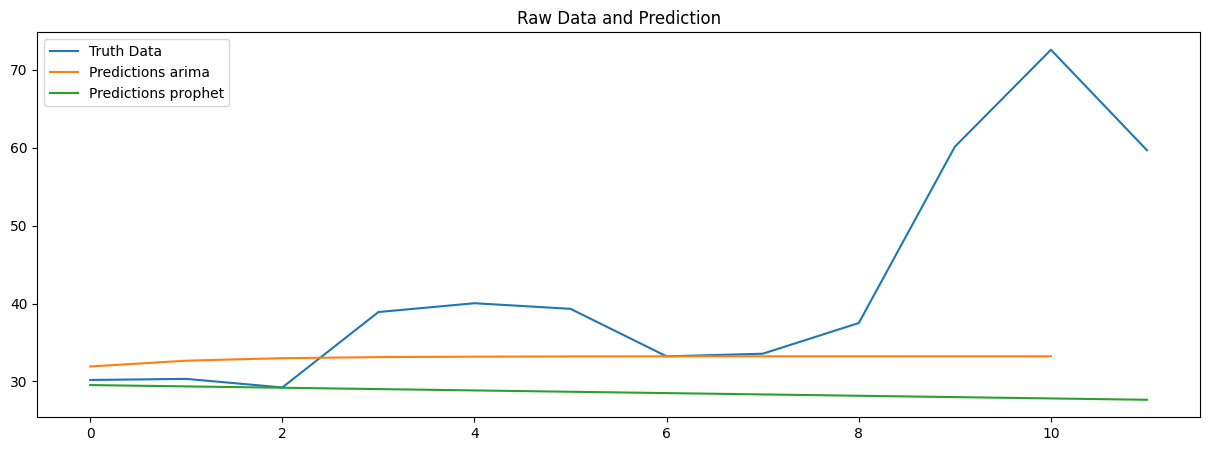

In [34]:
ax = test['y'].plot(figsize=(15, 5))
# test['prediction'].plot(ax=ax, style='-')
test['prediction_arima'].plot(ax=ax, style='-')
results['yhat'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions arima', 'Predictions prophet'])
ax.set_title('Raw Data and Prediction')
plt.show()